## Overview

We are going to create machine learning model to detect spam comment. You can do prediction using this model through API. You can see the API documentation in the end of page

### Import libraries

In [1]:
import pandas as pd
from unicodedata import *
import string
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

### Read excel file 

In [3]:
df = pd.read_excel('Comment Spam.xls')
df = df.drop('No', axis=1)

In [4]:
df.head(10)

,Comment,Class
0,this song is racist,0
1,and how many subscribers compared to her over ...,1
2,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
3,well done shakira,0
4,:D subscribe to me for daily vines,1
5,"Part 2. Holy Mary, pray for us Holy Mother of ...",1
6,"I really can&#39;t comprehend Miley Cyrus , s...",1
7,Nice song ^_^,0
8,This makes me miss the world cup,0
9,******* Facebook is LAME and so 2004! Check ou...,1


### Exploratory Data Analysts

create function to caltulate number of punctuation in each comment

In [5]:
def calculate_punctuation(data):
    num = 0
    for item in data:
        if item in string.punctuation:
            num += 1
    return num

In [6]:
df['punctuation_length'] = df['Comment'].apply(calculate_punctuation)

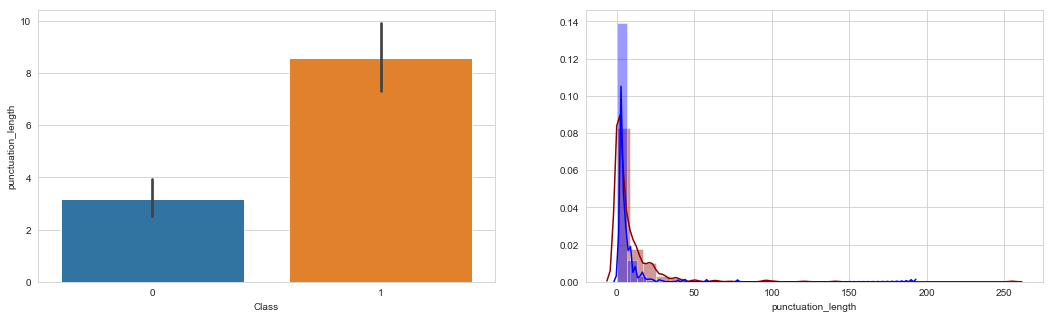

In [7]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.barplot(x='Class', y='punctuation_length', data=df)
plt.subplot(1,2,2)
sns.distplot(df[df['Class'] == 1]['punctuation_length'], color='darkred', bins=30)
sns.distplot(df[df['Class'] == 0]['punctuation_length'], color='blue', bins=30)

NOTE: 
* Spam comment have higher on average number of punctuation than ham comment. There also small range number of punctuation where comment are more likely spam. So we are not going to remove punctuation because it might be important for us

In [8]:
df['length'] = df['Comment'].apply(len)

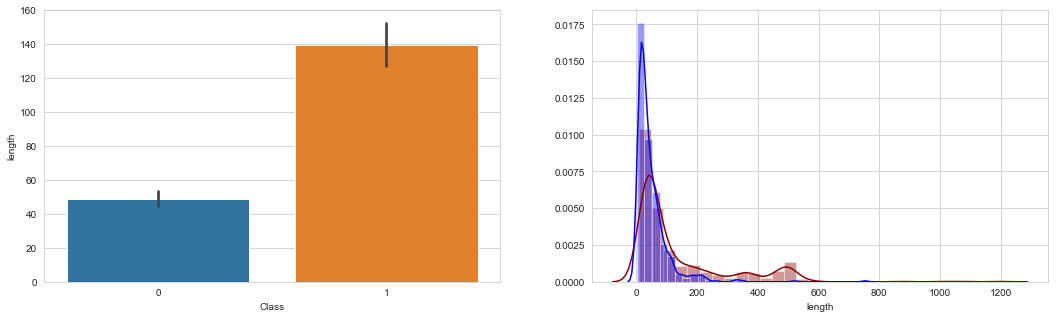

In [9]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.barplot(x='Class', y='length', data=df)
plt.subplot(1,2,2)
sns.distplot(df[df['Class'] == 1]['length'], color='darkred', bins=30)
sns.distplot(df[df['Class'] == 0]['length'], color='blue', bins=30)

NOTE: 
* We also see that spam comment have higher number of charachter than ham comment. So we are not going to do lematization on text processing so we can keep the length comment as long as posible

### Text Pre-processing

In [10]:
def processing_text_spam(data):
    # removing emoji
    data1 = data.encode('ascii', 'ignore').decode('ascii')
    
    # doing tokenization
    data5 = nlp(data1)
    data6 = [item for item in data5]
    
    # removing stop word
    data8 = [str(item) for item in data6 if item not in nlp.Defaults.stop_words]
    
    return ' '.join(data8)

In [11]:
df['CommentProcessed'] = df['Comment'].apply(processing_text_spam)

In [12]:
df.head(10)

,Comment,Class,punctuation_length,length,CommentProcessed
0,this song is racist,0,0,19,this song is racist
1,and how many subscribers compared to her over ...,1,0,55,and how many subscribers compared to her over ...
2,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1,3,57,HI ! CHECK OUT OUR AWESOME COVERS ! AND SAY WH...
3,well done shakira,0,0,17,well done shakira
4,:D subscribe to me for daily vines,1,1,34,:D subscribe to me for daily vines
5,"Part 2. Holy Mary, pray for us Holy Mother of ...",1,15,462,"Part 2 . Holy Mary , pray for us Holy Mother o..."
6,"I really can&#39;t comprehend Miley Cyrus , s...",1,9,244,"I really can&#39;t comprehend Miley Cyrus , ..."
7,Nice song ^_^,0,3,13,Nice song ^_^
8,This makes me miss the world cup,0,0,32,This makes me miss the world cup
9,******* Facebook is LAME and so 2004! Check ou...,1,22,145,* * * * * * * Facebook is LAME and so 2004 ! C...


### Splitting

In [13]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(
    df['CommentProcessed'], df['Class'],
    test_size = .2
)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## Naive Bayes

### Build a pipeline

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

modelNB = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('classifier', MultinomialNB()),
])

### Model Training

In [16]:
modelNB.fit(xTrain, yTrain)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Model Evaluation

#### Train Evaluation

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

In [18]:
prediction = modelNB.predict(xTrain)
print(classification_report(yTrain,prediction))
print('Accuracy = ', round(accuracy_score(yTrain,prediction)*100,2))
pd.DataFrame(confusion_matrix(yTrain, prediction), columns=['0 - predict', '1 - predict'], index=['0 - actual', '1 - actual'])

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       489
           1       0.96      0.98      0.97       551

    accuracy                           0.97      1040
   macro avg       0.97      0.97      0.97      1040
weighted avg       0.97      0.97      0.97      1040

Accuracy =  96.63


,0 - predict,1 - predict
0 - actual,465,24
1 - actual,11,540


#### Test Evaluation

In [19]:
prediction = modelNB.predict(xTest)
print(classification_report(yTest,prediction))
print('Accuracy = ', round(accuracy_score(yTest,prediction)*100,2))
pd.DataFrame(confusion_matrix(yTest, prediction), columns=['0 - predict', '1 - predict'], index=['0 - actual', '1 - actual'])

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       142
           1       0.81      0.95      0.87       118

    accuracy                           0.88       260
   macro avg       0.88      0.88      0.88       260
weighted avg       0.89      0.88      0.88       260

Accuracy =  87.69


,0 - predict,1 - predict
0 - actual,116,26
1 - actual,6,112


#### Consistency Evaluation

create evaluation function

In [20]:
def evaluation(X, Y, model):
    prediction = model.predict(X)
    precision = precision_score(Y, prediction) * 100
    recall = recall_score(Y, prediction) * 100
    f1 = f1_score(Y, prediction, average='macro') * 100
    accuracy = accuracy_score(Y,prediction) * 100
    return {
        "f1" : f1,
        "precision" : precision,
        "recall" : recall,
        "accuracy" : accuracy
    }

def calculation_metrics(xTrain, yTrain, xTest, yTest, model):
    model.fit(xTrain, yTrain)
    train_error = evaluation(xTrain, yTrain, model)
    validation_error = evaluation(xTest, yTest, model)
    return train_error, validation_error

doing evaluation

In [21]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
data = df['CommentProcessed']
target = df['Class']
train_error = []
validation_error = []
for trainIndex, valIndex in kf.split(data, target):
    xTrain, xTest = data.iloc[trainIndex], data.iloc[valIndex]
    yTrain, yTest = target.iloc[trainIndex], target.iloc[valIndex]
    
    trainError, valError = calculation_metrics(xTrain, yTrain, xTest, yTest, modelNB)
    
    train_error.append(trainError)
    validation_error.append(valError)

In [22]:
dfKFold = pd.DataFrame({
    "Train Precision" : [item['precision'] for item in train_error],
    "Train Recall" : [item['recall'] for item in train_error],
    "Train F1 Score" : [item['f1'] for item in train_error],
    "Train Accuracy" : [item['accuracy'] for item in train_error],
    "-" : ['-' for item in train_error],
    "Test Precision" : [item['precision'] for item in validation_error],
    "Test Recall" : [item['recall'] for item in validation_error],
    "Test F1 Sccore" : [item['f1'] for item in validation_error],
    "Test Accuracy" : [item['accuracy'] for item in validation_error],
})
additional = []
for item in dfKFold:
    if item != '-':
        additional.append(dfKFold[item].mean())
    else:
        additional.append('-')
dfKFold = pd.concat([dfKFold,pd.DataFrame(
    [additional],
    index=['Average'], columns=dfKFold.columns
)])
dfKFold

,Train Precision,Train Recall,Train F1 Score,Train Accuracy,-,Test Precision,Test Recall,Test F1 Sccore,Test Accuracy
0,95.928339,97.678275,96.661279,96.666667,-,91.304348,95.454545,93.066667,93.076923
1,95.928339,98.003328,96.832922,96.837607,-,92.957746,97.058824,94.589452,94.615385
2,95.686901,98.036007,96.655700,96.666667,-,85.937500,94.827586,90.734141,90.769231
3,95.695364,97.470489,96.493859,96.495726,-,93.670886,97.368421,94.408602,94.615385
4,96.387521,97.833333,97.005219,97.008547,-,86.842105,95.652174,89.865067,90.000000
5,96.320000,98.366013,97.170208,97.179487,-,73.972603,94.736842,83.076923,83.076923
6,96.563011,98.169717,97.261428,97.264957,-,86.666667,95.588235,89.898990,90.000000
7,96.387521,97.996661,97.090948,97.094017,-,88.000000,94.285714,89.865067,90.000000
8,95.967742,98.509934,97.087814,97.094017,-,95.081967,89.230769,92.300403,92.307692
9,96.052632,97.822446,96.834774,96.837607,-,94.666667,98.611111,96.086930,96.153846


#### ROC AUC

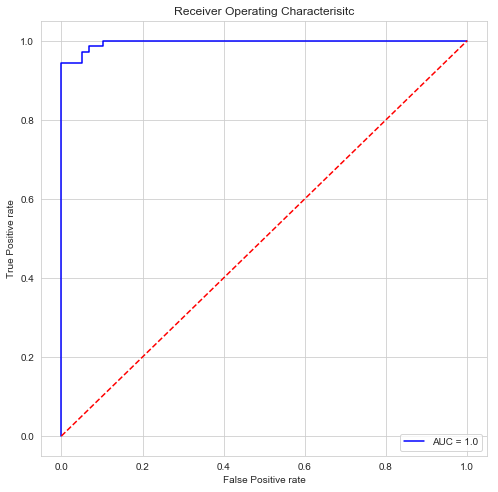

In [23]:
preds = modelNB.predict_proba(xTest)[:,1]
fpr, tpr, threshold = roc_curve(yTest, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
plt.grid(True)
plt.title('Receiver Operating Characterisitc')
plt.plot(fpr, tpr, 'b', label='AUC = {}'.format(round(roc_auc,2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')
plt.show()

## LinearSVC

### Build Pipeline

In [24]:
from sklearn.svm import SVC

modelSVC = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('classifier', SVC(kernel='linear',probability=True)),
])

### Model Training

In [25]:
modelSVC.fit(xTrain, yTrain)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
           

### Model Evaluation

#### Train Evaluation

In [26]:
prediction = modelSVC.predict(xTrain)
print(classification_report(yTrain,prediction))
print('Accuracy = ', round(accuracy_score(yTrain,prediction)*100,2))
pd.DataFrame(confusion_matrix(yTrain, prediction), columns=['0 - predict', '1 - predict'], index=['0 - actual', '1 - actual'])

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       573
           1       1.00      0.99      0.99       597

    accuracy                           0.99      1170
   macro avg       0.99      0.99      0.99      1170
weighted avg       0.99      0.99      0.99      1170

Accuracy =  99.15


,0 - predict,1 - predict
0 - actual,571,2
1 - actual,8,589


#### Test Evaluation

In [27]:
prediction = modelSVC.predict(xTest)
print(classification_report(yTest,prediction))
print('Accuracy = ', round(accuracy_score(yTest,prediction)*100,2))
pd.DataFrame(confusion_matrix(yTest, prediction), columns=['0 - predict', '1 - predict'], index=['0 - actual', '1 - actual'])

              precision    recall  f1-score   support

           0       0.93      0.98      0.96        58
           1       0.99      0.94      0.96        72

    accuracy                           0.96       130
   macro avg       0.96      0.96      0.96       130
weighted avg       0.96      0.96      0.96       130

Accuracy =  96.15


,0 - predict,1 - predict
0 - actual,57,1
1 - actual,4,68


#### Consistency Evaluation

In [28]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
data = df['CommentProcessed']
target = df['Class']
train_error = []
validation_error = []
for trainIndex, valIndex in kf.split(data, target):
    xTrain, xTest = data.iloc[trainIndex], data.iloc[valIndex]
    yTrain, yTest = target.iloc[trainIndex], target.iloc[valIndex]
    
    trainError, valError = calculation_metrics(xTrain, yTrain, xTest, yTest, modelSVC)
    
    train_error.append(trainError)
    validation_error.append(valError)

In [29]:
dfKFold = pd.DataFrame({
    "Train Precision" : [item['precision'] for item in train_error],
    "Train Recall" : [item['recall'] for item in train_error],
    "Train F1 Score" : [item['f1'] for item in train_error],
    "Train Accuracy" : [item['accuracy'] for item in train_error],
    "-" : ['-' for item in train_error],
    "Test Precision" : [item['precision'] for item in validation_error],
    "Tesbt Recall" : [item['recall'] for item in validation_error],
    "Test F1 Sccore" : [item['f1'] for item in validation_error],
    "Test Accuracy" : [item['accuracy'] for item in validation_error],
})
additional = []
for item in dfKFold:
    if item != '-':
        additional.append(dfKFold[item].mean())
    else:
        additional.append('-')
dfKFold = pd.concat([dfKFold,pd.DataFrame(
    [additional],
    index=['Average'], columns=dfKFold.columns
)])
dfKFold

,Train Precision,Train Recall,Train F1 Score,Train Accuracy,-,Test Precision,Tesbt Recall,Test F1 Sccore,Test Accuracy
0,99.334443,99.004975,99.144577,99.145299,-,98.461538,96.969697,97.692171,97.692308
1,99.495798,98.502496,98.973852,98.974359,-,98.529412,98.529412,98.458254,98.461538
2,99.503311,98.363339,98.887243,98.888889,-,100.000000,91.379310,96.069895,96.153846
3,99.489796,98.650927,99.059746,99.059829,-,98.630137,94.736842,96.069895,96.153846
4,99.494098,98.333333,98.888459,98.888889,-,95.454545,91.304348,93.066667,93.076923
5,99.669967,98.692810,99.143858,99.145299,-,94.736842,94.736842,95.313627,95.384615
6,99.495798,98.502496,98.973852,98.974359,-,95.588235,95.588235,95.374763,95.384615
7,99.493243,98.330551,98.888531,98.888889,-,95.588235,92.857143,93.822761,93.846154
8,99.501661,99.172185,99.315591,99.316239,-,100.000000,87.692308,93.822761,93.846154
9,99.661591,98.659966,99.145097,99.145299,-,98.550725,94.444444,96.126110,96.153846


#### ROC AUC

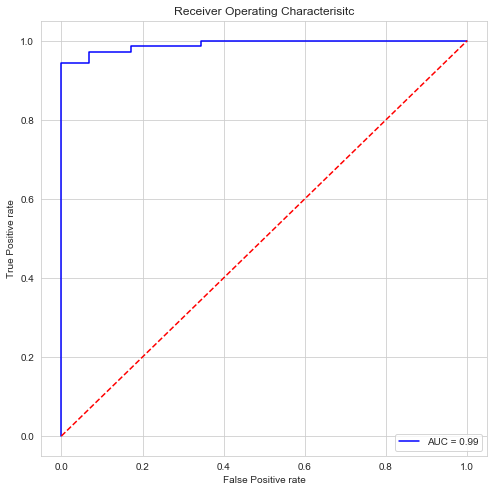

In [30]:
preds = modelSVC.predict_proba(xTest)[:,1]
fpr, tpr, threshold = roc_curve(yTest, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
plt.grid(True)
plt.title('Receiver Operating Characterisitc')
plt.plot(fpr, tpr, 'b', label='AUC = {}'.format(round(roc_auc,2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')
plt.show()

## Random Forest

### Buils Pipeline

In [31]:
from sklearn.ensemble import RandomForestClassifier

modelRF = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('classifier', RandomForestClassifier()),
])

### Model Training

In [32]:
modelRF.fit(xTrain, yTrain)

c:\users\m. khakim hidayad\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0

### Model Evaluation

#### Train Evaluation

In [33]:
prediction = modelRF.predict(xTrain)
print(classification_report(yTrain,prediction))
print('Accuracy = ', round(accuracy_score(yTrain,prediction)*100,2))
pd.DataFrame(confusion_matrix(yTrain, prediction), columns=['0 - predict', '1 - predict'], index=['0 - actual', '1 - actual'])

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       573
           1       1.00      0.99      1.00       597

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170

Accuracy =  99.66


,0 - predict,1 - predict
0 - actual,573,0
1 - actual,4,593


#### Test Evaluation

In [34]:
prediction = modelRF.predict(xTest)
print(classification_report(yTest,prediction))
print('Accuracy = ', round(accuracy_score(yTest,prediction)*100,2))
pd.DataFrame(confusion_matrix(yTest, prediction), columns=['0 - predict', '1 - predict'], index=['0 - actual', '1 - actual'])

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        58
           1       0.99      0.93      0.96        72

    accuracy                           0.95       130
   macro avg       0.95      0.96      0.95       130
weighted avg       0.96      0.95      0.95       130

Accuracy =  95.38


,0 - predict,1 - predict
0 - actual,57,1
1 - actual,5,67


#### Consistency Evaluation

In [35]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
data = df['CommentProcessed']
target = df['Class']
train_error = []
validation_error = []
for trainIndex, valIndex in kf.split(data, target):
    xTrain, xTest = data.iloc[trainIndex], data.iloc[valIndex]
    yTrain, yTest = target.iloc[trainIndex], target.iloc[valIndex]
    
    trainError, valError = calculation_metrics(xTrain, yTrain, xTest, yTest, modelRF)
    
    train_error.append(trainError)
    validation_error.append(valError)

In [36]:
dfKFold = pd.DataFrame({
    "Train Precision" : [item['precision'] for item in train_error],
    "Train Recall" : [item['recall'] for item in train_error],
    "Train F1 Score" : [item['f1'] for item in train_error],
    "Train Accuracy" : [item['accuracy'] for item in train_error],
    "-" : ['-' for item in train_error],
    "Test Precision" : [item['precision'] for item in validation_error],
    "Tesbt Recall" : [item['recall'] for item in validation_error],
    "Test F1 Sccore" : [item['f1'] for item in validation_error],
    "Test Accuracy" : [item['accuracy'] for item in validation_error],
})
additional = []
for item in dfKFold:
    if item != '-':
        additional.append(dfKFold[item].mean())
    else:
        additional.append('-')
dfKFold = pd.concat([dfKFold,pd.DataFrame(
    [additional],
    index=['Average'], columns=dfKFold.columns
)])
dfKFold

,Train Precision,Train Recall,Train F1 Score,Train Accuracy,-,Test Precision,Tesbt Recall,Test F1 Sccore,Test Accuracy
0,99.833055,99.170813,99.486796,99.487179,-,95.454545,95.454545,95.383523,95.384615
1,100.000000,99.001664,99.486926,99.487179,-,100.000000,92.647059,96.153619,96.153846
2,100.000000,98.854337,99.400823,99.401709,-,100.000000,86.206897,93.664717,93.846154
3,100.000000,98.145025,99.059812,99.059829,-,100.000000,82.894737,89.951840,90.000000
4,100.000000,99.000000,99.486964,99.487179,-,96.825397,88.405797,92.305871,92.307692
5,100.000000,99.019608,99.486315,99.487179,-,94.642857,92.982456,94.521702,94.615385
6,100.000000,99.667221,99.828947,99.829060,-,95.522388,94.117647,94.607407,94.615385
7,100.000000,99.165275,99.572484,99.572650,-,96.825397,87.142857,91.533953,91.538462
8,100.000000,99.006623,99.486796,99.487179,-,96.428571,83.076923,89.951840,90.000000
9,99.663866,99.329983,99.486998,99.487179,-,98.437500,87.500000,92.291271,92.307692


#### ROC AUC

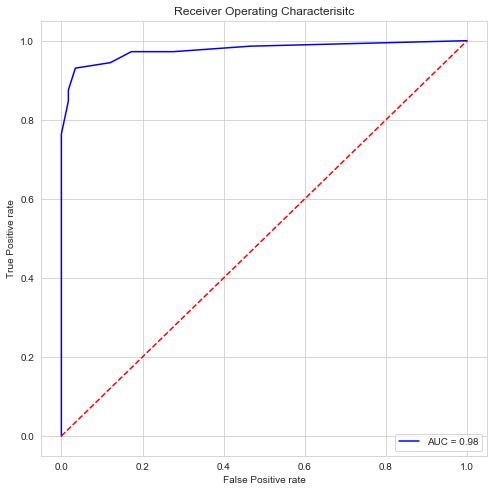

In [37]:
preds = modelRF.predict_proba(xTest)[:,1]
fpr, tpr, threshold = roc_curve(yTest, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
plt.grid(True)
plt.title('Receiver Operating Characterisitc')
plt.plot(fpr, tpr, 'b', label='AUC = {}'.format(round(roc_auc,2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive rate')
plt.xlabel('False Positive rate')
plt.show()

## Summary

We actually need model with good precision score when predicting spam. Because we don't want to predict ham / legitimate comment that might be important for us into spam. There are 2 model which have good precision score, LinearSVC and Random Forest. I decided to chose LinearSVC over Random Forest because it has better score for other metrics. Our LinearCSV model also have better consistency for precision score than Random Forest

## API Documentation

you can do prediction through this link http://khakimh-nlp.herokuapp.com/. <br>

> NOTE : 
> <br>It might be take a while to connect since we are using free hosting app from heroku and they are set the app to sleep after 30 minutes unused

You can send json file using this format:
```sh
{
    "text" : your_comment,
    "type" : "comment"
}
```

and it will return something like:
```sh
{
    "prediction": prediction
}
```